In [1]:
import os, sys
currentdir = os.path.dirname(os.path.realpath(os.path.abspath("")))
scriptsdir = os.path.dirname(currentdir)
if scriptsdir not in sys.path:
    sys.path.append(scriptsdir)

from customscripts import configuration
from customscripts import utils

# Common imports

import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
formatter = ticker.FuncFormatter(utils.human_format)

In [2]:
# get_dataset_df(weekNumber, datasetFileName)
data = utils.get_dataset_df(4, "nutrition_unicef_cleaned")

# first is the food data 
data_food = utils.get_dataset_df(3, "all_categories") \
    .drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Classification', 'Trade Flow Code', 'Reporter Code', \
 'Reporter', 'Partner Code', 'Partner', 'Qty', 'Qty Unit', 'Qty Unit Code', 'Netweight (kg)', 'Category Code', 'Development Category', '% Malnutritioned Childern < 5 years old'])

data_food = data_food.loc[data_food['Year'] >= 2007]
data_food = data_food.loc[data_food['Trade Flow'] == 'Import']
data_food['Year'] = data_food['Year'].astype(int).astype(str)

# then is the data of industrial product
data_industrial = utils.get_dataset_df(4, "final") \
    .drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Classification', 'Trade Flow Code', 'Reporter Code', \
 'Reporter', 'Partner Code', 'Partner', 'Category Code', 'Development Category']) 
data_industrial = data_industrial.dropna(subset=['Year'])

# remove the decimals in the column 'Year'
data_industrial['Year'] = data_industrial['Year'].astype(int).astype(str)

In [3]:
import zipfile

population_zip = zipfile.ZipFile(scriptsdir +'\dataset\week4.zip', 'r')
population_csv =population_zip.open('week4/population.csv')
data_population = pd.read_csv(population_csv)

Change the trade value data to the trade value per capita

In [4]:
# Initialization
data_food['Trade Value per capita'] = data_food['Trade Value (US$)']
data_industrial['Trade Value per capita'] = data_industrial['Trade Value (US$)']

years_sequence = sorted(data_industrial['Year'].unique().tolist())
reporter_sequence = sorted(data_food['Reporter ISO'].unique().tolist())

# implement the trade value per capita
for _, reporter in enumerate(reporter_sequence):
    # print(reporter) # for debugging
    for count, year in enumerate(years_sequence):
        data_food['Trade Value per capita'] = data_food['Trade Value per capita'] \
            .mask( (data_food['Reporter ISO'] == reporter) & (data_food['Year'] == year ), \
                data_food['Trade Value (US$)'] / data_population.loc[data_population['Country Code'] == reporter][year].values )

        data_industrial['Trade Value per capita'] = data_industrial['Trade Value per capita'] \
            .mask( (data_industrial['Reporter ISO'] == reporter) & (data_industrial['Year'] == year ), \
                data_industrial['Trade Value (US$)'] / data_population.loc[data_population['Country Code'] == reporter][year].values )

In [3]:
import help_functions as HF

In [28]:
# blue_patch = mpatches.Patch(color='blue', label='Base Metals')
# orange_patch = mpatches.Patch(color='orange', label='Chemicals and Plastics')
# green_patch = mpatches.Patch(color='green', label='Guns')
# red_patch = mpatches.Patch(color='red', label='Minerals')
# industrial_handle = [blue_patch, orange_patch, green_patch, red_patch]

So the data in this week have basically the structure as following:

Food
 - Fruits and Vegetables
 - Meat and Seafood
 - Grains and Cereals
 - Beverages
 - Dairy

Industrial Product
 - Chemicals and Plastics
 - Guns
 - Base Metals
 - Minerals


For the analysis of food data you can refer to my main notebook in week 3, week 4 try to analyze Industrial data and try to find some correlations and trade patterns of individual countries. But keep in mind that the industrial data contains both the import and export data, and in general, trade value in Industrial Product is much larger than trade value in food. Let's first see how the two categories changes over time.

### 3.1 Reporter import and export trade value
What do they import the most and least, or the most frequent? So in this part solved problems are list as below:
- Each reporter's trade value (import and export), number of transactions of different categories
- Each partner's trade value (import and export), number of transactions of different categories

Firstly, there are totally two kinds of trade flows, so we need to plot these two kinds of trade flows separately. The value above the x-axis is the export trade value, while the value below the x-axis is the import trade value of each country. The net trade value is calculated as the export trade value minus import trade value. Then we plot the annual trade value per capita of each industrial product for different reporters according to their development level. Conclusions of high development level can be made as below:
- All these highly developed countries depend a lot on the import trade value of the 'Minerals', which fluctuates a lot over the years, but for USA, this trend is a bit different with other countries: it tries to achieve more export trade value gradually.
- But for USA it seems always to achieve the negative net export in all products.
- DEU is more export-oriented, especially in "Chemicals and Plastics"; while other high-developed countries always achieve negative trade balance.
- Some interesting time point would be the year like 2008(global crisis), 2011(top point), 2016(small shrank), maybe we should pay special attention to these time point when doing the predicting in the future.

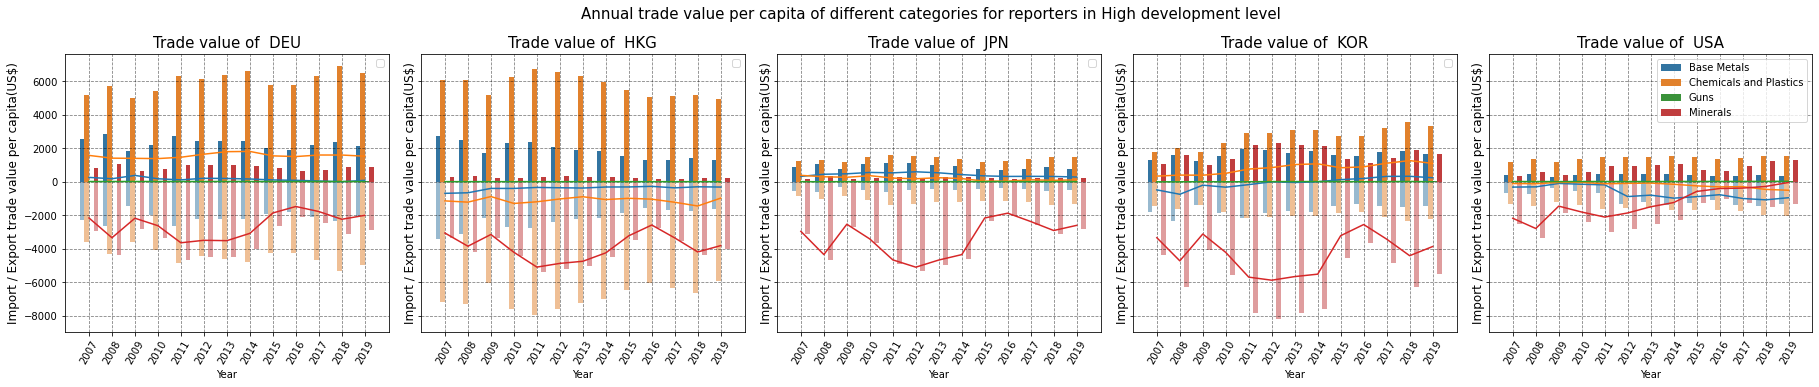

In [65]:
HF.annual_cate_development(data_industrial, 'High')

In the last weeks we found that the trade value of the USA, CHN are much larger than other countries in the same developed level, but the trade value per capita on the contrary is much smaller, and the same is also hold for HKG, so actually this new metric (trade value per capita can tell us more precisely about the domestic happiness level)
 - The net export's mode changes a lot among these reporters, for example, BRA can realize positive net export in Minerals, MEX seems lose this trade surplus over the years gradually, while CHN, THA and TUR never realize it.
 - And compare with the reporters in high development level, we find an interesting point that, the net exports lines for the category "Minerals" for countries BRA, THA, TUR, DEU, HKG, JPN, KOR and PAK in the following development level show some similar shape, so a very coarse and reasonable concept is that these lines may have some common paradigms to follow.
 - But there is always expectations, like the net export lines for MEX and USA is totally in different direction, due to their geographic neighbourhood relation, in this category the two countries may have some complementarities.

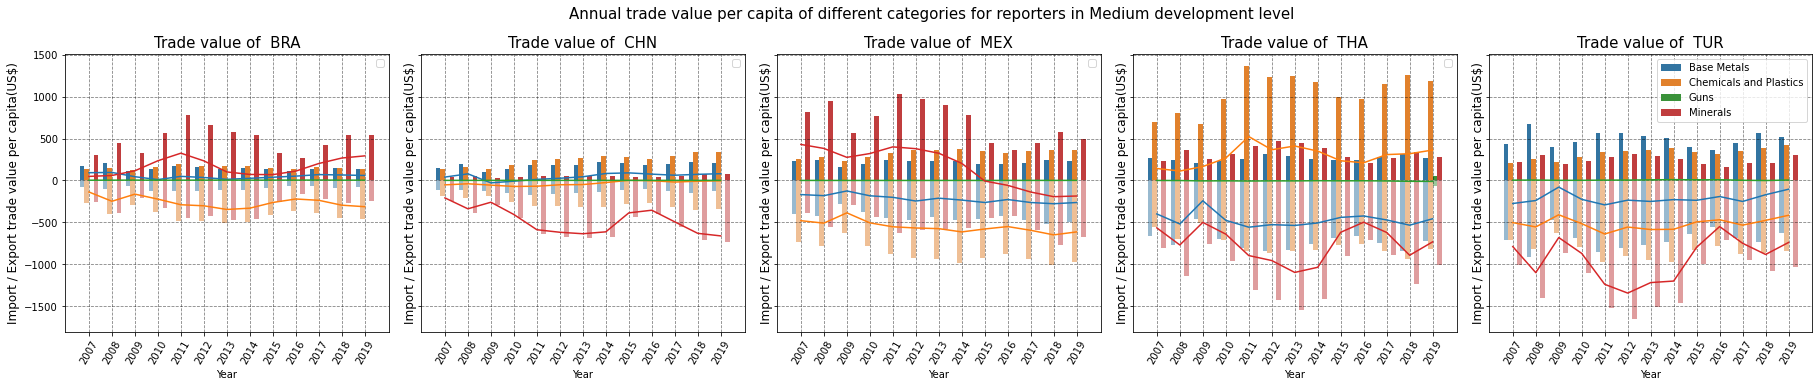

In [66]:
HF.annual_cate_development(data_industrial, 'Medium')

Conclusions for low developed countries are that:
 - The most obvious point is that NGA is export-oriented, whose export category also focus on "Mineral".
 - As mentioned before, PAK's net export have the similar shape like some other countries.
 - EGY here instead here have the similar shape to MEX, but the shift time point is a bit earlier.
 - The remaining result is not that obvous. This may lead to the conclusion that the large the trade value is, the more obvious is the trade mode, since what we guess may have some paradigms is mainly "Minerals", which occupies the largest trade value.

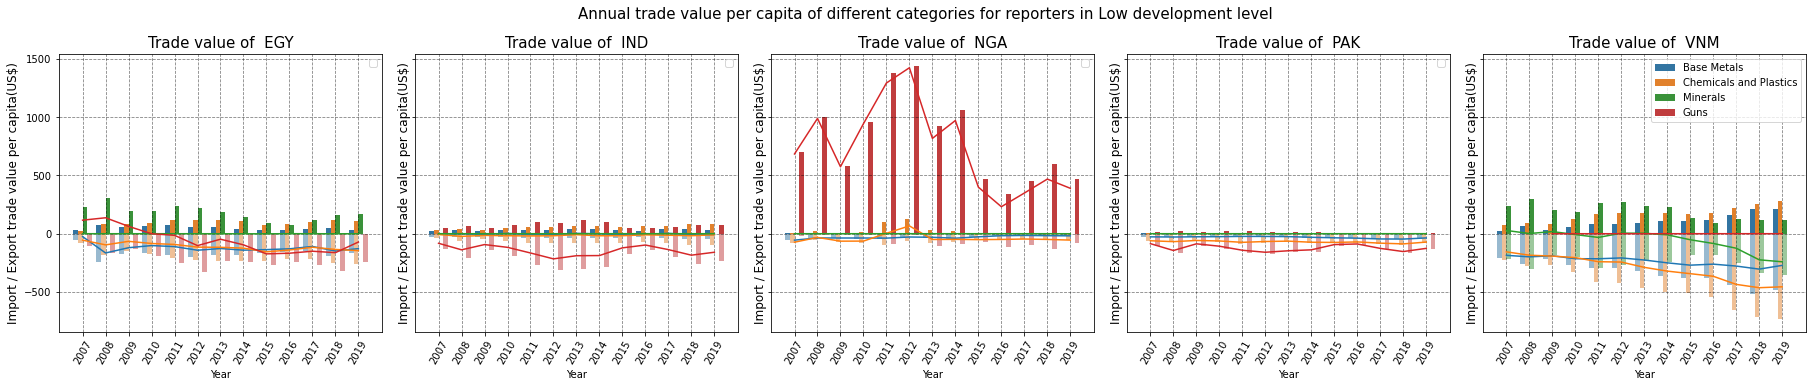

In [67]:
HF.annual_cate_development(data_industrial, 'Low')

### Mix Reporters in the same Development Level
- These countries in highly developed levels import "Minerals" most, while countries in lowly developed level export "Minerals" most.
- For other 3 products, highly developed countries seem to achieve balanced surplus, while medium or low developed countries are more import oriented;

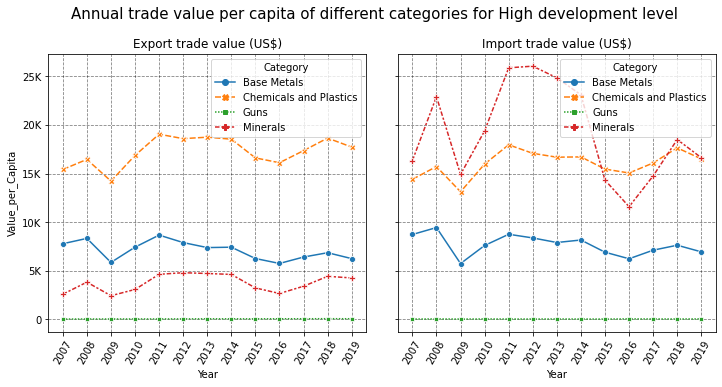

In [16]:
HF.development_category_value(data_industrial, 'High')

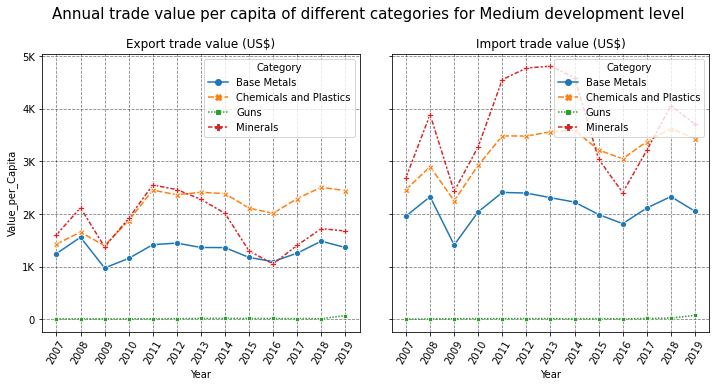

In [17]:
HF.development_category_value(data_industrial, 'Medium')

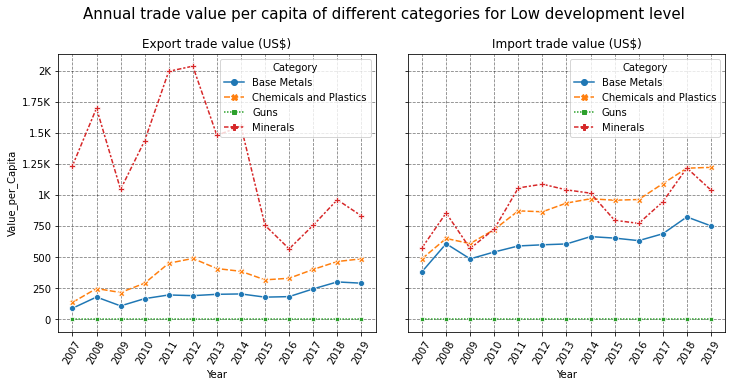

In [18]:
HF.development_category_value(data_industrial, 'Low')

Since the food data only contains the import data, we just analyze the import patter here. Here show the 2 version, with difference in if subplots share y-axis or not.
- These countries' trade value in industrial products is obviously higher than the food import value, so the two subplot not using the same y-axis here.
- We can see that both the food data and industrial data drops in 2009, which is the result of global economic crisis.
- The trade value in 2016 seems dropped a bit in industrial products, but the food seems less influenced.
- The food trade value has a total trend of increasing, but the industrial products trade value fluctuate a lot, especially in 'Minerals'

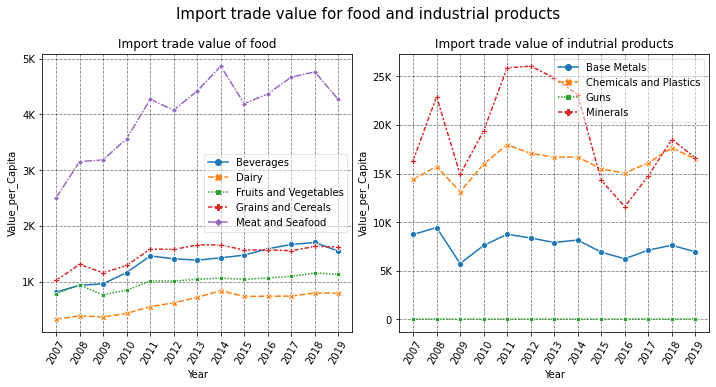

In [31]:
# Not share the y-axis 
HF.import_value_pattern(data_food, data_industrial, 'High')

- The hierarchy of food import trade value of medium developted countries is very obvious

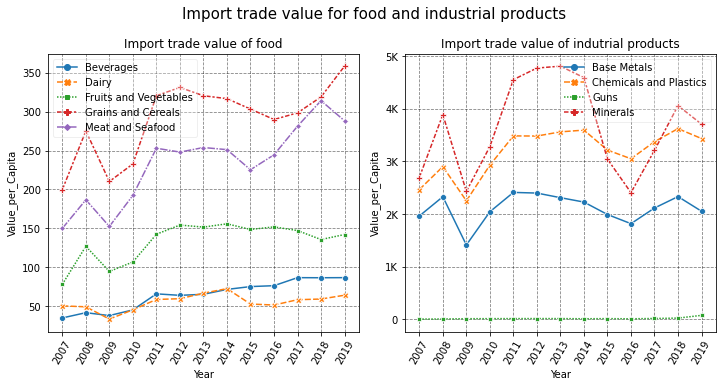

In [34]:
HF.import_value_pattern(data_food, data_industrial, 'Medium')

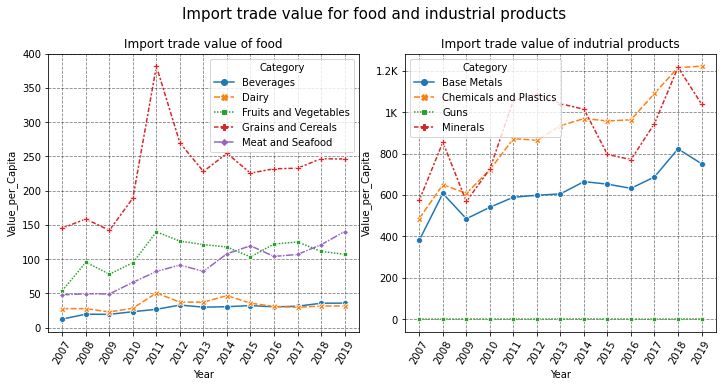

In [27]:
HF.import_value_pattern(data_food, data_industrial, 'Low')

### Mix population level
Let's first see the information in population, and then decided the populated level of different countries

In [13]:
# decide the populated level here, uncomment to see the result
# data_industrial[{'Reporter ISO', 'Population in 2005 (in million)', 'Population in 2010 (in million)', 'Population in 2014 (in million)', 'Population in 2018 (in million)'}].value_counts() \
#     .reset_index() \
#     .sort_values(by='Population in 2005 (in million)', ascending=False)

According to their population number, but not the population density, I choose to make the categorization as below:
- Highly populated: CHN, IND, USA, BRA (listed in the top 5 countries w.r.t. total population)
- Medium populated: PAK, NGA, JPN, MEX (listed in the top 6-11 countries w.r.t. total population)
- Low populated: VNM, DEU, EGY, TUR, THA, KOR, HKG


In [9]:
high_populated = ['CHN', 'IND', 'USA', 'BRA']
medium_populated = ['PAK', 'NGA', 'JPN', 'MEX']
low_populated = ['VNM', 'DEU', 'EGY', 'TUR', 'THA', 'KOR', 'HKG']
populated_level = [high_populated, medium_populated, low_populated]

- The trade pattern of diffetent populated level varies not a lot, in industrial always like: Mineral > Chemical > Metal > Guns.
- Industrial value seems to droped in 2016, but the food value seems less influenced.
- For those highly populated countries, the trade value in industrial product is much more than trade value of food, which is explainable, since the more developed a country is, then the less they will cost in the food. Instead, they can have much more focus on the development of industrial product. But for lowly developed countries, thing are just on the contrary.

In [37]:
high_populated = ['CHN', 'IND', 'USA', 'BRA']
medium_populated = ['PAK', 'NGA', 'JPN', 'MEX']
low_populated = ['VNM', 'GER', 'EGY', 'TUR', 'THA', 'KOR', 'HKG']
populated_level = [high_populated, medium_populated, low_populated]

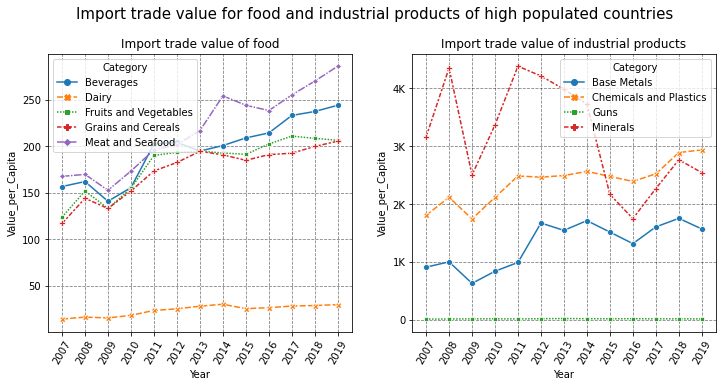

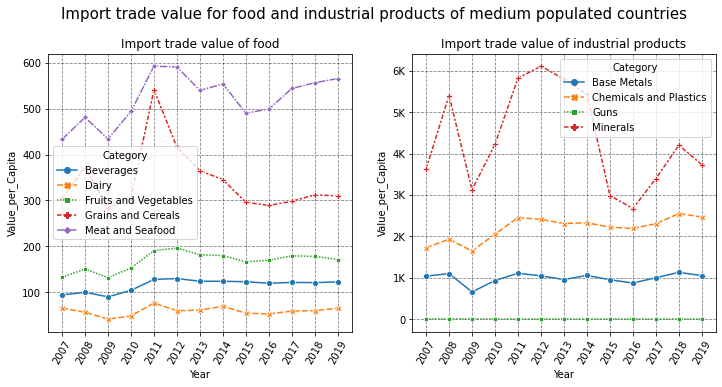

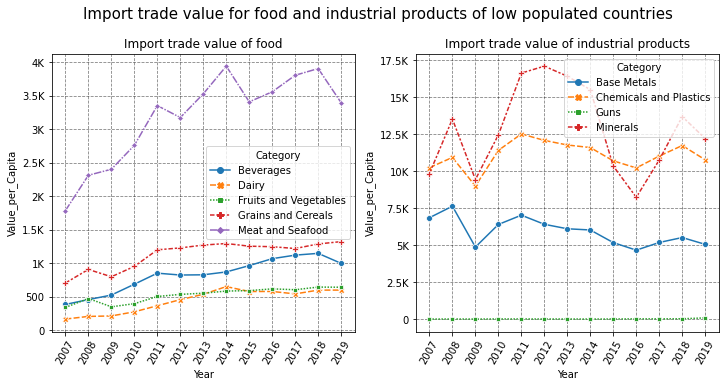

In [38]:
# here not share the y-axis 
HF.populated_value_pattern(data_food, data_industrial, populated_level)

Here we choose the top 6 partners according to their total trade value over 20 years, which is USA, CHN, CAN, JPN, SAU, KOR. We can make several conclusions as below:
- USA and CHN import most "Chemicals and Plastics", at the same time CHN also import a lot "Base Metals"
- CAN and SAU in the contrast import 'Minerals' most, the trade value in this category is much more than the remaining categories
- The export trade value don't have such a big variance as the import trade value, with the category 'Chemicals and Plastics' always being the first place in all these 6 partners

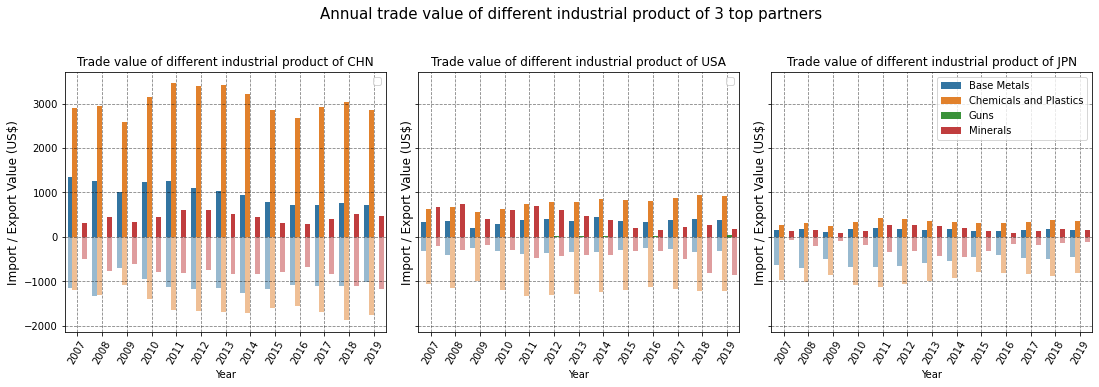

In [52]:
HF.top_partner_category_value(data_industrial)

- Basically, we can deduce the main economic activity of these bottom partners according to their trade value in industrial product.
- But these countries have never been heard before, there is not a large necessity to analyze them.

In [12]:
# pass the ugly bottom countries
# HF.bottom_partner_category_value(data_industrial)

### Number of transactions
- Although the trade value of gun is raletively small compared to other industrial product, but the number of transactions is much visible.
- Normally it is always the 'Chemicals and Plastics' that has the largest transaction number all the industrial product, but in USA since 2012, the first place is taken by the 'Base Metals' in Import.
- The transaction number seldomly changes over time, the order is mainly the same for all the reporters:
Chemicals and Plastics > Base Metals > Mineral > Guns

In [15]:
# first deal with the number of transaction of each reporters
# HF.reporter_transaction_num(data_industrial)

Here we choose the top 6 partners according to their total number of transactions over the 20 years, and the chosen partners are GBR, CHN, ITA, FRA, NLD, BEL. Conclusion are made as below:
- Although the "Minerals" has the largest trade value, but its number of transactions is not so large. Instead, there seems to be more transactions in 'Chemicals and Plastics' in the field of trade numbers.
- The transaction number seldomly changes over time, the order is mainly the same for all the top partners:
Chemicals and Plastics > Base Metals > Mineral > Guns

In [14]:
# HF.partner_top_transaction_num(data_industrial)

Some conclusions are made below, but I don't think they are of great importance.
- BLM seems don't trade with any countries since 2014, or maybe just because the lack of data. Same is also hold for BVT since 2018.
- SPM seems to export more than import in number of transaction.
- Have a look at the map, and you will find that these countries are all islated island, thus the number of transaction is very low.


In [11]:
# HF.partner_bottom_transaction_num(data_industrial)

### 3.2 Reporter - Partner Relationship
In this part solved problems are list as below:
- Each reporter's trade value (Import), number of transactions with its top 20 partners
- Each reporter's trade value (Import), number of transactions with its bottom 20 partners??? The effect is not very good.

There are three kind of trade flows, first we show the number of each kind of trade flow as below. As shown in Series "country_count", "Import" is the most important one, since the other two happens rarely, hence we only analyze the import data here

Here we choose each reporter's top 5 partners according the trade value between two countries over 20 years, then we show the annual trade value over each partner per reporter over 20 years. Since we share the y-axis, so we group the countries by their developmnet level.
- CAN is of great importance to the USA, and its trade value is also larger than other reporters, same is also hold for USA to MEX.
- CHN import a lot from AUS, while export a lot to USA.


In [13]:
# HF.reporter_top_partner_trade_value(data_industrial, 'High')

In [14]:
# HF.reporter_top_partner_trade_value(data_industrial, 'Medium')

- NGA's export trade value with USA dropped sice 2013, maybe there was something between the two countries?
- IND's import value reached at top value in the year 2013.

In [15]:
# HF.reporter_top_partner_trade_value(data_industrial, 'Low')

According to the result above, we can find that there is an obvious dump in trade values for each reporter in each food categories in the year 2009, while in the year 2011 all reach a local maximul point. Then contact to the reality, it's mainly because that......(tbd)

In [26]:
direction = {'Top': False, 'Bottom': True}

In [28]:
# then is the number of transaction of each reporter with its bottom 20 partners
# HF.num_transaction_of_reporter(data_industrial, direction['Bottom'])

### 3.3 Details
Now dig into small details of certain reporter


In [29]:
HF.print_report_partner_info(data_industrial)

#########################################################################################################
Let's focus on the Import trade value:
The first Import partner of DEU is ['NLD'] in trade value, and ['NLD'] in transaction number over 20 years
The first Import partner of HKG is ['CHN'] in trade value, and ['CHN'] in transaction number over 20 years
The first Import partner of JPN is ['AUS'] in trade value, and ['KOR'] in transaction number over 20 years
The first Import partner of KOR is ['SAU'] in trade value, and ['USA'] in transaction number over 20 years
The first Import partner of USA is ['CAN'] in trade value, and ['CHN'] in transaction number over 20 years
The first Import partner of BRA is ['USA'] in trade value, and ['USA'] in transaction number over 20 years
The first Import partner of CHN is ['AUS'] in trade value, and ['USA'] in transaction number over 20 years
The first Import partner of MEX is ['USA'] in trade value, and ['CHN'] in transaction number over 20 years

- As we have said, the trade pattern between NGA and USA seems to changed over the years, so we show the details betweent the two countries here.
- The trade category is mainly 'Minerals' between the countries, and NGA seldom import from USA, but just export 'Minerals'.

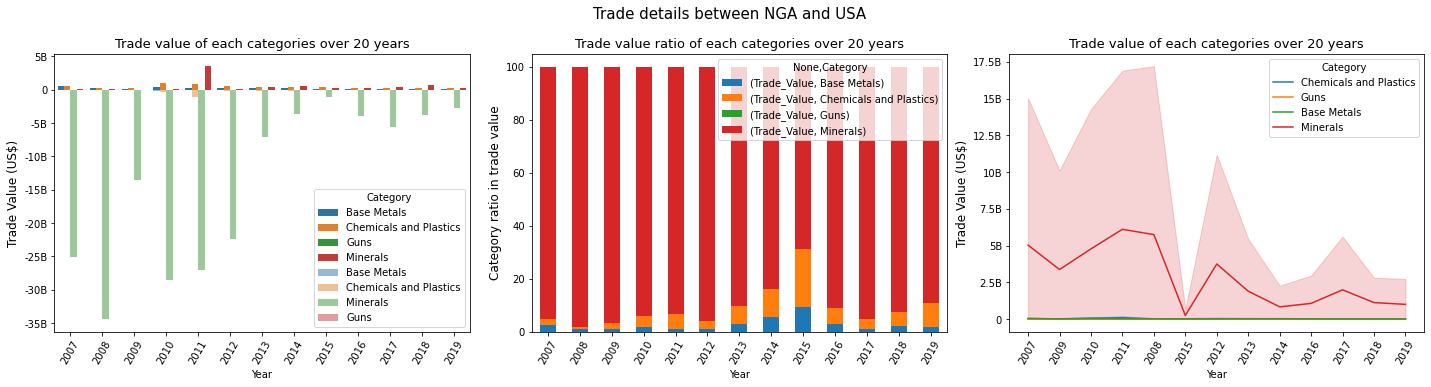

In [12]:
HF.reporter_partner_detail(data_industrial, 'NGA', 'USA')

### 3.4 Correlations
There may be some correlation between different food categories, or other dimensions. Firstly, we can see that both the transaction number and trade value in DEU in very consistent in each food categories, thus we want to see if there are some correlations betweent the number of transaction and the trade value

In [13]:
def plot_num_value_trend(data, reporter):

    fig, ax = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
    ax_unpack = ax.ravel()
    
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.3, hspace=0.3, top=0.8)

    reporter_data = data.loc[data['Reporter ISO'] == reporter]
    category = reporter_data['Category'].unique()

    for count, cat in enumerate(category):
        data_plot_1 = reporter_data.loc[reporter_data['Category'] == cat]
        sns.lineplot(data=data_plot_1, x='Year', y='Trade Value (US$)', ax=ax_unpack[count])
        ax_unpack[count].yaxis.set_major_formatter(formatter)
        ax_unpack[count].yaxis.set_label_text("Trade Value (US$)", fontsize=12)
        ax_unpack[count].set_title("Relation in category " + cat)
        ax_unpack[count].xaxis.set_tick_params(rotation=60)
        ax2 = ax_unpack[count].twinx()
        data_plot_2 = data_plot_1['Year'].value_counts() \
            .reset_index() \
            .rename(columns={'index': 'Year', 'Year': 'Count'}) \
            .sort_values(by='Year', ascending=True)
        sns.lineplot(data=data_plot_2, x='Year', y='Count', ax=ax2, color='r')
        ax2.yaxis.set_label_text("Number of transaction", fontsize=12)
        # share the second y-axis
        ax2.set_ylim(0, 2500)
        
    fig.suptitle("Trend of trade value and number of transaction for " + reporter, fontsize=15)

In [14]:
import matplotlib.ticker as ticker
formatter = ticker.FuncFormatter(utils.human_format)

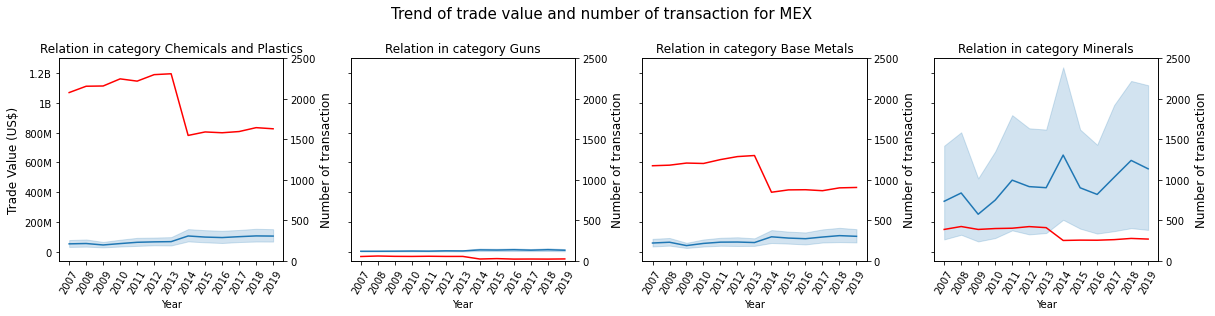

In [15]:
plot_num_value_trend(data_industrial, 'MEX')

Then here want to see if there is some correlations between the trade value of import and export for different reporters

In [34]:
def plot_num_value_correlation(data, reporter):

    fig, ax = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
    ax_unpack = ax.ravel()
    
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.3, hspace=0.3, top=0.8)

    reporter_data = data.loc[data['Reporter ISO'] == reporter][{'Year', 'Trade Value (US$)', 'Category'}]
    category = reporter_data['Category'].unique()
    value_num_data = reporter_data.groupby(['Year', 'Category']) \
        .agg(['sum', 'count']) \
        .reset_index() \

    new_columns = value_num_data.columns.get_level_values(0).values
    new_columns[3] = "Count"
    value_num_data.columns = new_columns

    for count, cat in enumerate(category):
        plot_data = value_num_data.loc[value_num_data['Category'] ==cat]
        sns.regplot(data=plot_data, x='Count', y='Trade Value (US$)', ax=ax_unpack[count])
        ax_unpack[count].yaxis.set_major_formatter(formatter)
        ax_unpack[count].yaxis.set_label_text("Trade Value (US$)", fontsize=12)
        ax_unpack[count].set_title("Relation in category " + cat)
        ax_unpack[count].grid(color='k', linestyle='--');
        
    fig.suptitle("Relation between trade value and number of transaction for " + reporter, fontsize=15)

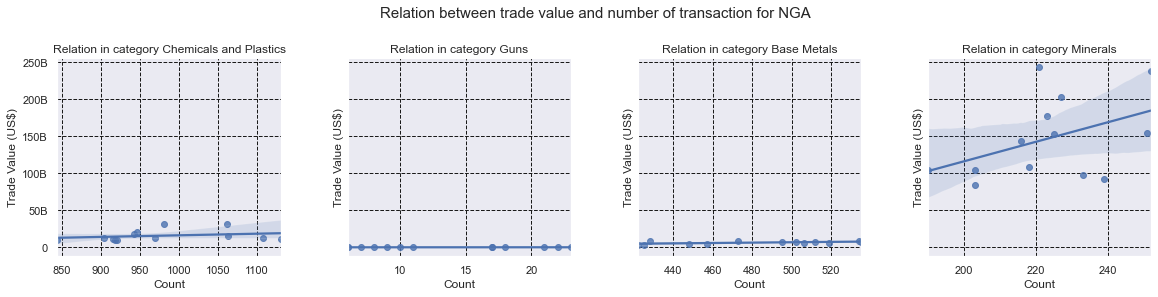

In [35]:
plot_num_value_correlation(data_industrial, 'NGA')

In [16]:
def plot_import_export_relation(data, reporter):
    
    fig, ax = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
    ax_unpack = ax.ravel()
    
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.4, hspace=0.25, top=0.8)
    
    reporter_data = data.loc[data['Reporter ISO'] == reporter][{'Year', 'Trade Value (US$)', 'Category'}]
    category = reporter_data['Category'].unique()
    

    for count, cat in enumerate(category):
        import_data = data.loc[data['Reporter ISO'] == reporter] \
            .loc[data['Category'] == cat] \
            .sort_values(by='Year', ascending=True)
        sns.lineplot(data=import_data, x='Year', y='Trade Value (US$)', ax=ax_unpack[count])
        ax_unpack[count].yaxis.set_major_formatter(formatter)
        ax_unpack[count].yaxis.set_label_text("Export Value (US$)", fontsize=12)
        ax_unpack[count].set_title("Import and export trade value for " + cat)
        ax_unpack[count].xaxis.set_tick_params(rotation=60)

        ax2 = ax_unpack[count].twinx()
        export_data = data.loc[data['Partner ISO'] == reporter] \
            .loc[data['Category'] == cat] \
            .sort_values(by='Year', ascending=True)

        sns.lineplot(data=export_data, x='Year', y='Trade Value (US$)', ax=ax2, color='r')
        ax2.yaxis.set_label_text("Import Value (US$)", fontsize=12)
        ax2.get_shared_y_axes().join(ax2, ax_unpack[count])
        ax2.yaxis.set_major_formatter(formatter)

    fig.suptitle("Import and export trade value of different categories for " + reporter, fontsize=15)

Show the annual import and export trade value for a singe reporter, here we take the USA for an example.

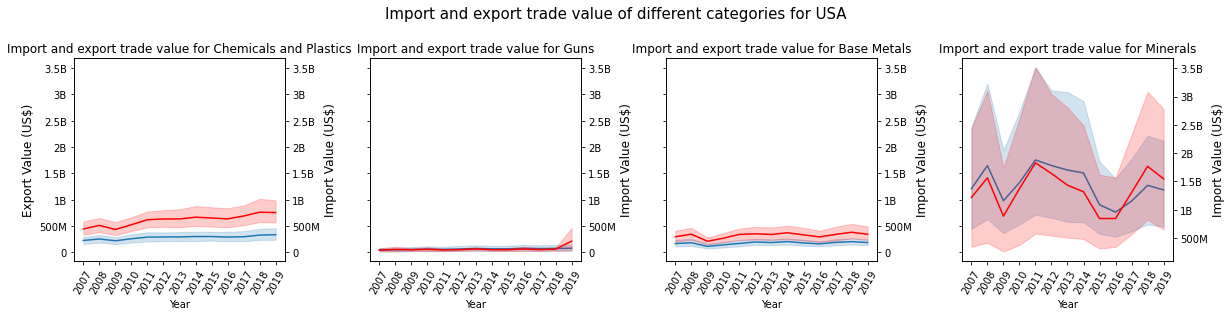

In [17]:
plot_import_export_relation(data_industrial, "USA")